<a href="https://colab.research.google.com/github/markpoxley/Bayesian_Crystallography/blob/main/Bayesian_Crsytallography_V1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install atomai -q

     |████████████████████████████████| 143 kB 8.9 MB/s 
     |████████████████████████████████| 193 kB 43.5 MB/s 
     |████████████████████████████████| 498 kB 37.0 MB/s 
     |████████████████████████████████| 865 kB 36.5 MB/s 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from PIL import Image
import atomai as aoi
import matplotlib.gridspec as gridspec
import torch 
import warnings


#Import Data

Install pydm3reader:

In [3]:
dm3r = !python -c "from pydm3reader import dm3_lib as dm3" 2>/dev/null; echo $?
if int(dm3r[0]):
    !echo "Installing package for reading dm3 files..."
    !wget -qq https://bitbucket.org/piraynal/pydm3reader/get/d06ab6b3aa0f.zip
    !unzip d06ab6b3aa0f.zip -d pydm3reader > /dev/null && mv pydm3reader/*/* pydm3reader
    !find ./pydm3reader -type d -empty -delete
    !cd pydm3reader && pip install -q .

Installing package for reading dm3 files...
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


In [4]:
from pydm3reader import dm3_lib as dm3

Download data supplied by Matthew F. Chisholm

In [5]:
#Sr3Ru2O7 image stack
!gdown https://drive.google.com/uc?id=1BvlV3vH6sEHPaNFPkGjMdsYtAvszkuYV

#LSMO-NiO image stack
!gdown https://drive.google.com/uc?id=1srxRNHoXRv0HDxIkJsH_hh5__HuPgDGg

Downloading...
From: https://drive.google.com/uc?id=1BvlV3vH6sEHPaNFPkGjMdsYtAvszkuYV
To: /content/12-3D Stack copy.dm3
21.6MB [00:00, 101MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1srxRNHoXRv0HDxIkJsH_hh5__HuPgDGg
To: /content/HAADF-42908.dm3
4.80MB [00:00, 42.2MB/s]


In [6]:
# When the data is loaded, it should be in the form of numpy array
# Of the shape (f,h,w), where f is frame, h is height, and w is width
# For single image f = 1, for stack f = number of images in stack

# Example of stack
imgfile_sro = '/content/12-3D Stack copy.dm3' 
dm3f_sro = dm3.DM3(imgfile_sro)
imgdata_sro = dm3f_sro.imagedata
print(imgdata_sro.shape)

#Example of single image
imgfile_lsmo = '/content/HAADF-42908.dm3'
dm3f_lsmo = dm3.DM3(imgfile_lsmo)
imgdata_lsmo = dm3f_lsmo.imagedata
imgdata_lsmo = np.expand_dims(imgdata_lsmo, axis = 0)
print(imgdata_lsmo.shape)
# Use if single image in stack
#imgdata = np.expand_dims(imgdata, axis = 0)
norm = lambda x: (x - x.min()) / x.ptp()
imgdata_lsmo = norm(imgdata_lsmo)
imgdata_sro = norm(imgdata_sro)

(20, 512, 512)
(1, 1024, 1024)


Atomic Semantic Segmentation

Load trained weights into a model skeleton.

In [7]:
!gdown https://drive.google.com/uc?id=1K46kbZoqFV2ao-xPDNN1oDrDSCogqBSp

Downloading...
From: https://drive.google.com/uc?id=1K46kbZoqFV2ao-xPDNN1oDrDSCogqBSp
To: /content/cubic-best_weights.pt
4.03MB [00:00, 130MB/s]


In [8]:
#@title Load model skeleton { form-width: "15%" }
import torch
import torch.nn as nn
import torch.nn.functional as F


class resatomsegnet_s2(nn.Module):
    '''Builds  a fully convolutional neural network model'''
    def __init__(self, nb_classes=1, nb_filters=32):
        '''
        Args:
            nb_classes (int): number of classes to be predicted
            nb_filters (int): number of filters in the first convolutional layer
        '''
        super(resatomsegnet_s2, self).__init__()
        self.pxac = 'softmax' if nb_classes > 1 else 'sigmoid'
        self.c1 = conv2dblock(1, nb_filters)
        self.c2 = ResModule(nb_filters, nb_filters*2, res_depth=2)
        self.bn = ResModule(nb_filters*2, nb_filters*4, res_depth=2)
        self.upsample_block1 = upsample_block(nb_filters*4, nb_filters*2)
        self.c3 = ResModule(nb_filters*4, nb_filters*2, res_depth=2) 
        self.upsample_block2 = upsample_block(nb_filters*2, nb_filters)
        self.c4 = conv2dblock(nb_filters*2, nb_filters)
        self.px = nn.Conv2d(nb_filters, nb_classes, kernel_size = 1, stride = 1, padding = 0)
    
    def forward(self, x):
        '''Defines a forward path'''
        # Contracting path
        c1 = self.c1(x)
        d1 = F.max_pool2d(c1, kernel_size=2, stride=2)      
        c2 = self.c2(d1)
        d2 = F.max_pool2d(c2, kernel_size=2, stride=2)      
        # Bottleneck 
        bn = self.bn(d2)
        # Expanding path
        u2 = self.upsample_block1(bn)
        u2 = torch.cat([c2, u2], dim = 1)
        u2 = self.c3(u2)
        u1 = self.upsample_block2(u2)
        u1 = torch.cat([c1, u1], dim = 1)
        u1 = self.c4(u1)
        # pixel-wise classification
        px = self.px(u1)
        if self.pxac == 'sigmoid':
            output = torch.sigmoid(px)
        elif self.pxac == 'softmax':
            output = F.log_softmax(px, dim=1)
        return output

class conv2dblock(nn.Module):
    '''
    Creates a block consisting of convolutional
    layer, leaky relu and (optionally) dropout and
    batch normalization
    '''
    def __init__(self, input_channels, output_channels,
                 kernel_size=3, stride=1, padding=1,
                 use_batchnorm=False, lrelu_a=0.01,
                 dropout_=0):
        '''
        Args:
            input_channels: number of channels in the previous/input layer
            output_channels: number of the output channels for the present layer
            kernel_size: size (in pixels) of convolutional filter
            stride: value of convolutional filter stride
            padding: value of padding at the edges
            use_batchnorm (boolean): usage of batch normalization
            lrelu_a: value of alpha parameter in leaky/paramteric ReLU activation
            dropout_: value of dropout
        '''
        super(conv2dblock, self).__init__()
        block = []
        block.append(nn.Conv2d(input_channels,
                               output_channels,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding))
        if dropout_ > 0:
            block.append(nn.Dropout(dropout_))
        block.append(nn.LeakyReLU(negative_slope=lrelu_a))
        if use_batchnorm:
            block.append(nn.BatchNorm2d(output_channels))
        self.block = nn.Sequential(*block)

    def forward(self, x):
        '''Forward path'''
        output = self.block(x)
        return output

class ResBlock(nn.Module):
    """
    Builds a residual block
    """
    def __init__(self, nb_filters_in=20, nb_filters_out=40, lrelu_a=0,
                use_batchnorm=False):
        """
        Args:
            nb_filters_in (int): number of channels in the block input
            nb_filters_out (int): number of channels in the block output
            lrelu_a=0 (float): negative slope value for leaky ReLU
        """
        super(ResBlock, self).__init__()
        self.lrelu_a = lrelu_a
        self.use_batchnorm = use_batchnorm
        self.c0 = nn.Conv2d(nb_filters_in,
                            nb_filters_out,
                            kernel_size=1,
                            stride=1,
                            padding=0)
        self.c1 = nn.Conv2d(nb_filters_out,
                           nb_filters_out,
                           kernel_size=3,
                           stride=1,
                           padding=1)
        self.c2 = nn.Conv2d(nb_filters_out,
                           nb_filters_out,
                           kernel_size=3,
                           stride=1,
                           padding=1)
        self.bn1 = nn.BatchNorm2d(nb_filters_out)
        self.bn2 = nn.BatchNorm2d(nb_filters_out)

    def forward(self, x):
        """Defines forward path"""
        x = self.c0(x)
        residual = x
        out = self.c1(x)
        if self.use_batchnorm:
            out = self.bn1(out)
        out = F.leaky_relu(out, negative_slope=self.lrelu_a)
        out = self.c2(out)
        if self.use_batchnorm:
            out = self.bn2(out)
        out += residual
        out = F.leaky_relu(out, negative_slope=self.lrelu_a)
        return out

class ResModule(nn.Module):
    """
    Stitches multiple convolutional blocks together
    """
    def __init__(self, input_channels, output_channels, res_depth, lrelu_a=0.01, use_batchnorm=False):
        """
        Args:
            input_channels (int): number of filters in the input layer
            output_channels (int): number of channels in the output layer
            res_depth (int): number of residual blocks in a residual module
        """
        super(ResModule, self).__init__()
        res_module = []
        for i in range(res_depth):
            input_channels = output_channels if i > 0 else input_channels
            res_module.append(
                ResBlock(input_channels, output_channels, lrelu_a=lrelu_a, use_batchnorm=use_batchnorm))
        self.res_module = nn.Sequential(*res_module)

    def forward(self, x):
        """Defines a forward path"""
        x = self.res_module(x)
        return x


class upsample_block(nn.Module):
    '''
    Defines upsampling block performed either with
    bilinear interpolation followed by 1-by-1
    convolution or with a transposed convolution
    '''
    def __init__(self, input_channels, output_channels,
                 mode='interpolate', kernel_size=1,
                 stride=1, padding=0):
        '''
        Args:
            input_channels: number of channels in the previous/input layer
            output_channels: number of the output channels for the present layer
            mode: upsampling mode (default: 'interpolate')
            kernel_size: size (in pixels) of convolutional filter
            stride: value of convolutional filter stride
            padding: value of padding at the edges
            '''
        super(upsample_block, self).__init__()
        self.mode = mode
        self.conv = nn.Conv2d(
            input_channels, output_channels,
            kernel_size = kernel_size,
            stride = stride, padding = padding)
        self.conv_t = nn.ConvTranspose2d(
            input_channels, output_channels,
            kernel_size=2, stride=2, padding = 0)

    def forward(self, x):
        '''Defines a forward path'''
        if self.mode == 'interpolate':
            x = F.interpolate(
                x, scale_factor=2,
                mode='bilinear', align_corners=False)
            return self.conv(x)
        return self.conv_t(x)

In [9]:
weights_path = torch.load("/content/cubic-best_weights.pt", map_location="cpu")
model = resatomsegnet_s2()
model.load_state_dict(weights_path)
model.eval();

In [10]:
p = aoi.predictors.SegPredictor(model, logits=False)

Make a prediction for SRO:

In [11]:
sro_nn_output, sro_coordinates = p.run(imgdata_sro)

Batch 20/20
20 images were decoded in approximately 35.2826 seconds


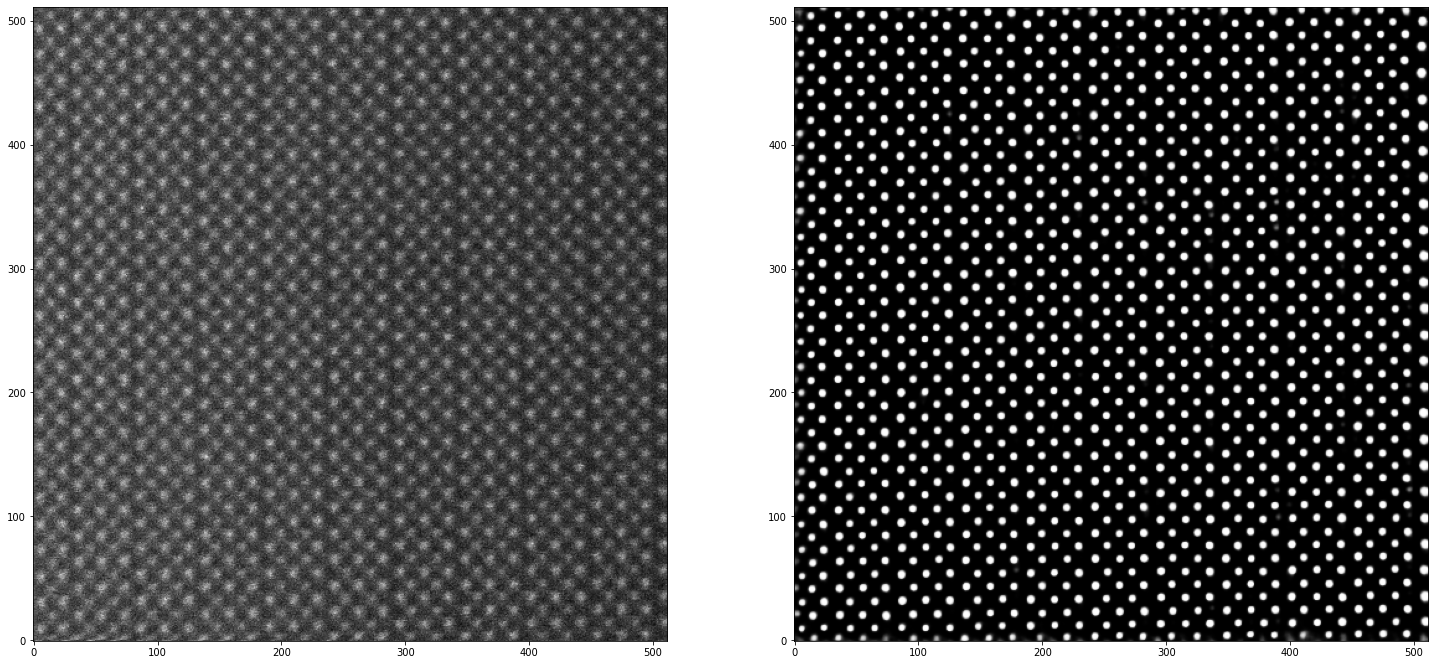

In [12]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 12))
ax1.imshow(imgdata_sro[0], cmap='gray', origin="lower")
ax2.imshow(sro_nn_output.squeeze()[0], cmap='gray',origin="lower")

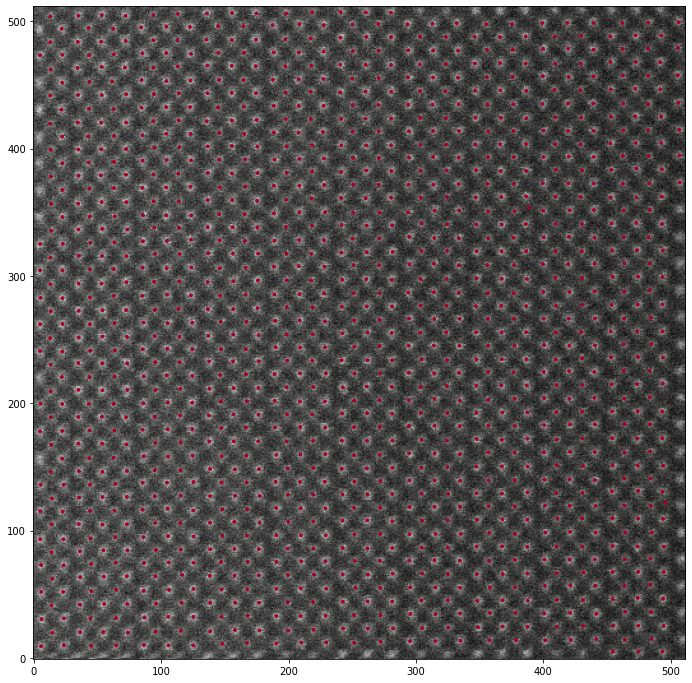

In [13]:
aoi.utils.plot_coord(imgdata_sro[0], sro_coordinates[0], fsize=12)

Make a prediction for the the LSMO-NiO

In [14]:
lsmo_nn_output, lsmo_coordinates = p.run(imgdata_lsmo)


Batch 1/1
1 image was decoded in approximately 7.5002 seconds


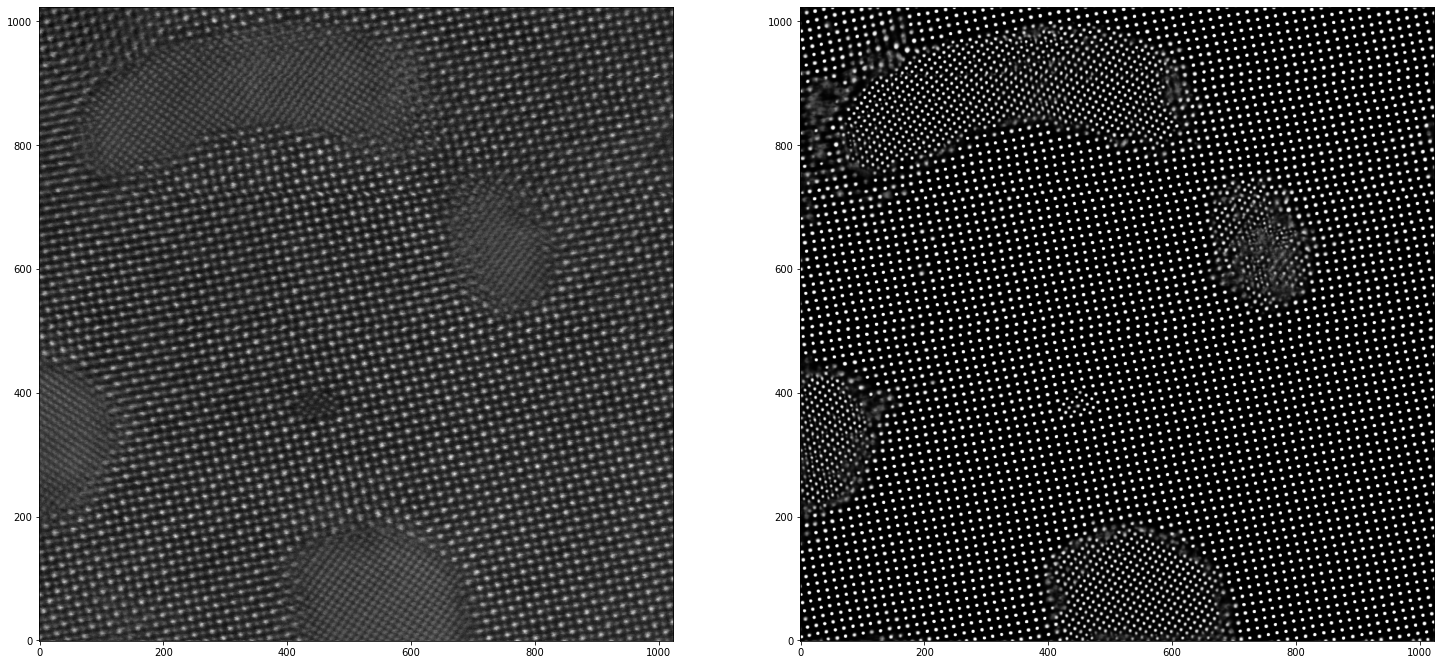

In [15]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 12))
ax1.imshow(imgdata_lsmo[0], cmap='gray', origin="lower")
ax2.imshow(lsmo_nn_output.squeeze(), cmap='gray',origin="lower")

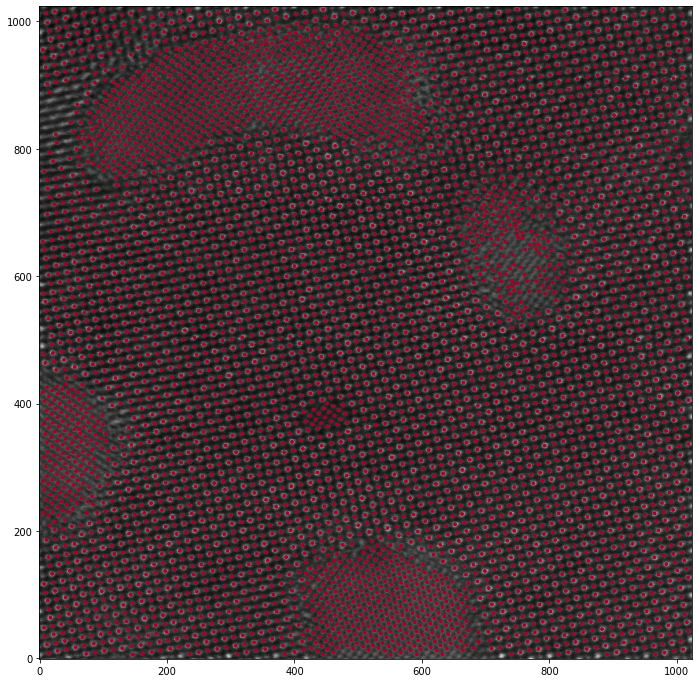

In [16]:
aoi.utils.plot_coord(imgdata_lsmo[0], lsmo_coordinates[0], fsize=12)

Now create an image stack

(20815, 34, 34, 1)


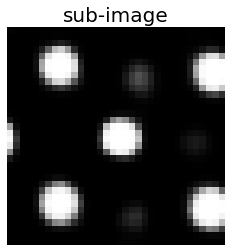

In [ ]:
# Set image data to process
#imgdata = np.expand_dims(imgdata_sro, axis = 3)    # uncomment this line to use SRO images 
imgdata = sro_nn_output  # uncomment this line to use semantically segmented SRO images 
#imgdata = np.expand_dims(imgdata_lsmo,  axis = 3)     # uncomment this line to use LSMO images 
#imgdata = lsmo_nn_output  # uncomment this line to use semantically segmented LSMO images 

# Select matchin coordinates
coord = sro_coordinates  #uncomment this line if using SRO
#coord = lsmo_coordinates  #uncomment this line if using LSMO

# Set windowsize
window = 34

stack, com, frames = aoi.utils.extract_subimages(imgdata, coord, window_size=window, coord_class=0)

print(stack.shape)

fig, ax = plt.subplots()
ax.imshow(stack[200,...,0], cmap=plt.cm.gray)
ax.set_title(r'sub-image', fontsize=20)
  
plt.axis('off')
plt.show()


Train Model using rVAE

In [ ]:
input_dim = (window, window)

# Intitialize model
rvae = aoi.models.rVAE(input_dim,translation = False) 
# Train
rvae.fit(np.squeeze(stack), training_cycles=500, batch_size=32, loss='mse')

Epoch: 1/500, Training loss: 52.9822
Epoch: 2/500, Training loss: 52.1636
Epoch: 3/500, Training loss: 51.6086
Epoch: 4/500, Training loss: 46.4385
Epoch: 5/500, Training loss: 34.8586
Epoch: 6/500, Training loss: 27.8428
Epoch: 7/500, Training loss: 23.8968
Epoch: 8/500, Training loss: 20.6369
Epoch: 9/500, Training loss: 19.2305
Epoch: 10/500, Training loss: 18.2967
Epoch: 11/500, Training loss: 17.6094
Epoch: 12/500, Training loss: 17.0234
Epoch: 13/500, Training loss: 16.4836
Epoch: 14/500, Training loss: 15.9692
Epoch: 15/500, Training loss: 15.4643
Epoch: 16/500, Training loss: 15.0440
Epoch: 17/500, Training loss: 14.6235
Epoch: 18/500, Training loss: 14.2270
Epoch: 19/500, Training loss: 13.8706
Epoch: 20/500, Training loss: 13.5277
Epoch: 21/500, Training loss: 13.1573
Epoch: 22/500, Training loss: 12.8352
Epoch: 23/500, Training loss: 12.5468
Epoch: 24/500, Training loss: 12.3054
Epoch: 25/500, Training loss: 12.0507
Epoch: 26/500, Training loss: 11.8550
Epoch: 27/500, Traini

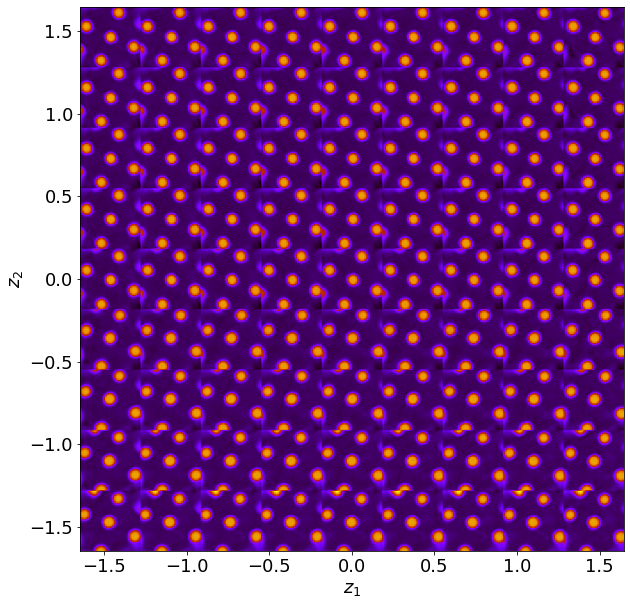

array([[0.15710496, 0.16101104, 0.15663059, ..., 0.06576404, 0.08327261,
        0.09955909],
       [0.12418156, 0.12443355, 0.11915483, ..., 0.07981041, 0.09130732,
        0.09590399],
       [0.10198869, 0.1002074 , 0.09327396, ..., 0.08039995, 0.08309864,
        0.0820977 ],
       ...,
       [0.14500605, 0.09127006, 0.07223152, ..., 0.20368687, 0.23633784,
        0.22402033],
       [0.12713571, 0.08659194, 0.06871078, ..., 0.16858095, 0.20027705,
        0.20023801],
       [0.1294857 , 0.10553901, 0.09408976, ..., 0.13754346, 0.16579014,
        0.17132116]])

In [ ]:
rvae.manifold2d(d=9, origin='upper')

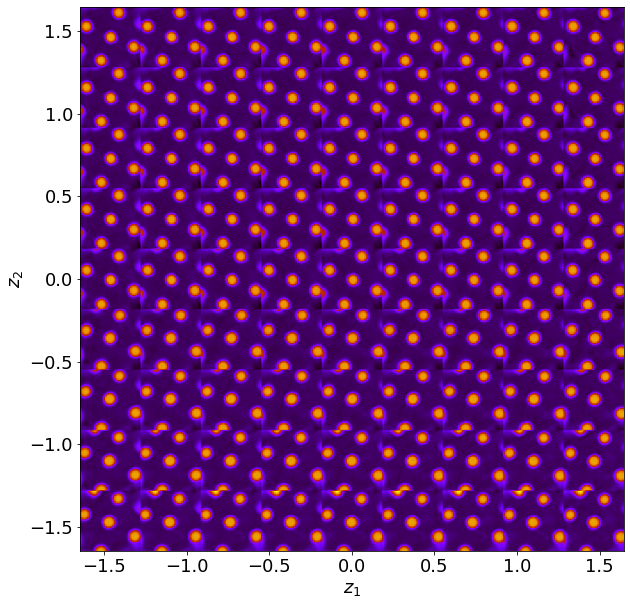

In [ ]:
tableu = rvae.manifold2d(d=9, origin='upper')

In [ ]:
z_mean, z_sd = rvae.encode(np.squeeze(stack))


In [ ]:
print(z_mean.shape)

(20815, 3)


In [ ]:
z1, z2  = z_mean[:,0], z_mean[:, 1:3]

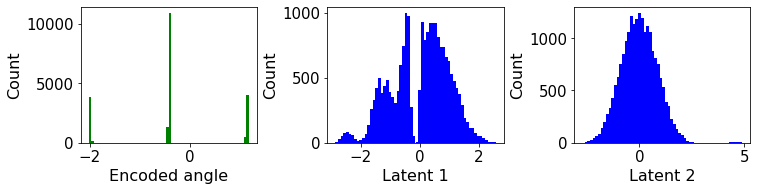

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 2.5))
ax[0].hist(z1, bins=60, color='green')
ax[1].hist(z2[:, 0], bins=60, color='blue')
ax[2].hist(z2[:, 1], bins=60, color='blue')
ax[0].set_xlabel("Encoded angle", fontsize=16)
ax[1].set_xlabel("Latent 1", fontsize=16) #X-offset for rVAE, L1 for rrVAE
ax[2].set_xlabel("Latent 2", fontsize=16) #Y-offset for rVAE, L2 for rrVAE
for _ax in fig.axes:
    _ax.set_ylabel("Count", fontsize=16)
    _ax.tick_params(labelsize=15)
plt.subplots_adjust(wspace=0.4)

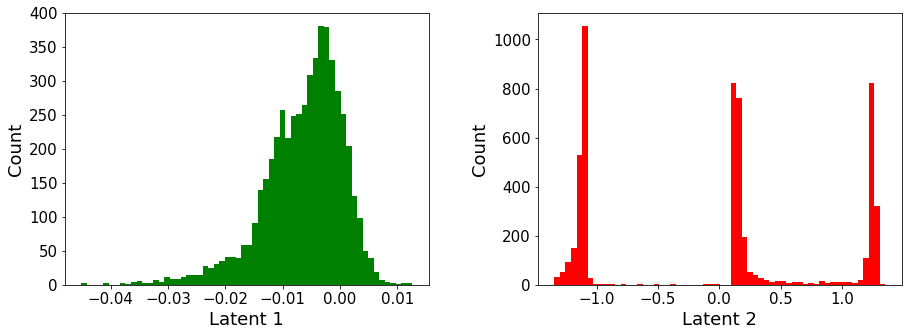

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(z3[:,0], bins=60, color='green')
ax[1].hist(z3[:, 1], bins=60, color='red')
ax[0].set_xlabel("Latent 1", fontsize=18)
ax[1].set_xlabel("Latent 2", fontsize=18) #X-offset for rVAE, L1 for rrVAE
for _ax in fig.axes:
    _ax.set_ylabel("Count", fontsize=18)
    _ax.tick_params(labelsize=15)
plt.subplots_adjust(wspace=0.3)

In [ ]:
frame = 0 # select frame
work_image = imgdata[frame,:,:,0]
com_i = com[np.where(frames == frame)] # get coordinates for this frame
z1_i = z1[np.where(frames == frame)] # get latent variables (image) for this frame
z2_i = z2[np.where(frames == frame)] # get latent variables (image) for this frame
#z3_i = z3[np.where(frames == frame)] # get latent variables (image) for this frame
z_all_i = np.concatenate((np.expand_dims(z1_i,axis = 1), z2_i), axis = 1)


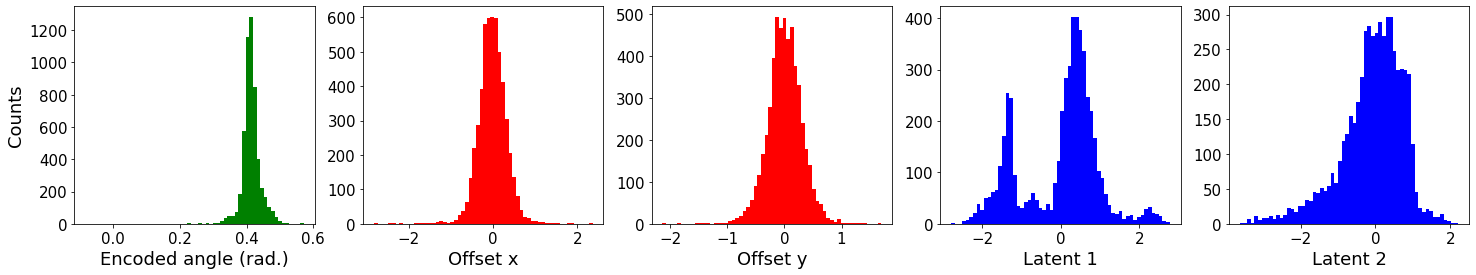

In [ ]:
ncols = 5
nrows = 1
gs2 = gridspec.GridSpec(nrows, ncols)
fig2 = plt.figure(figsize = (25,4))

for i in range(5):
    if i == 0:
      ax = fig2.add_subplot(gs2[i])
      ax.hist(z1, bins=60, color='green')
      ax.set_xlabel("Encoded angle (rad.)", fontsize=18)
      ax.set_ylabel("Counts", fontsize=18)
      ax.tick_params(labelsize=15)
    elif i == 1:
      ax = fig2.add_subplot(gs2[i])
      ax.hist(z2[:,0], bins=60, color='red')
      ax.set_xlabel("Offset x", fontsize=18)
      #ax.set_ylabel("Count", fontsize=18)
      ax.tick_params(labelsize=15)
    elif i == 2:
      ax = fig2.add_subplot(gs2[i])
      ax.hist(z2[:,1], bins=60, color='red')
      ax.set_xlabel("Offset y", fontsize=18)
      #ax.set_ylabel("Count", fontsize=18)
      ax.tick_params(labelsize=15)
    elif i == 3:
      ax = fig2.add_subplot(gs2[i])
      ax.hist(z3[:,0], bins=60, color='blue')
      ax.set_xlabel("Latent 1", fontsize=18)
      #ax.set_ylabel("Count", fontsize=18)
      ax.tick_params(labelsize=15)
    elif i == 4:
      ax = fig2.add_subplot(gs2[i])
      ax.hist(z3[:,1], bins=60, color='blue')
      ax.set_xlabel("Latent 2", fontsize=18)
      #ax.set_ylabel("Count", fontsize=18)
      ax.tick_params(labelsize=15)




plt.show()

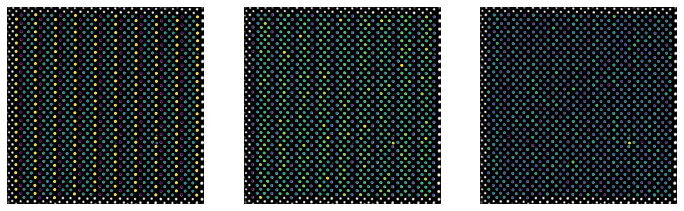

In [ ]:
gs2 = gridspec.GridSpec(1, 3)
fig2 = plt.figure(figsize = (12,4))  

for i in range(3):
    ax2 = fig2.add_subplot(gs2[i])
#      plt.imshow(work_image, cmap="gray", origin = 'lower')
    plt.axis('off')
    plt.imshow(work_image, cmap="gray")
    plt.scatter(com_i[:, 1], com_i[:, 0], c=z_all_i[:, i], s = 3)
    plt.axis('off')
plt.show()

In [ ]:
print('Encoded angle', np.amin(z1), np.amax(z1))
#print('Encoded offset', np.amin(z2[:,0]), np.amax(z2[:,0]))
#print('Encoded offset', np.amin(z2[:,1]), np.amax(z2[:,1]))
print('Latent 1', np.amin(z2[:,0]), np.amax(z2[:,0]))
print('Latent2', np.amin(z2[:,1]), np.amax(z2[:,1]))


Encoded angle -2.02508 1.1818423
Latent 1 -2.8628247 2.5726361
Latent2 -2.7226412 4.9036045


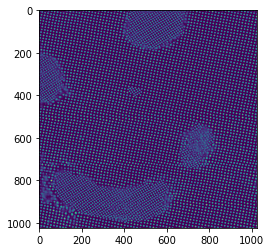

In [ ]:
imgdata.shape
plt.imshow(work_image)

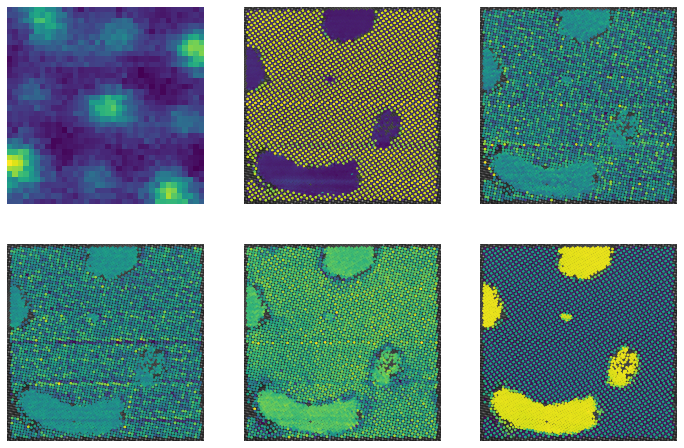

In [ ]:
gs2 = gridspec.GridSpec(2, 3)
fig2 = plt.figure(figsize = (12,8))  

for i in range(6):
    ax2 = fig2.add_subplot(gs2[i])
    if i == 0:
#      ax2.imshow(work_image, cmap="gray", origin = 'lower')
      ax2.imshow(stack[200,...,0])
      plt.axis('off')
    else:  
#      plt.imshow(work_image, cmap="gray", origin = 'lower')
      plt.axis('off')
      plt.imshow(work_image, cmap="gray")
      plt.scatter(com_i[:, 1], com_i[:, 0], c=z_all_i[:, i-1], s = 3)
      plt.axis('off')
plt.show()

In [ ]:
frame = 0 # select frame
work_image = imgdata[frame,:,:,0]
com_i = com[np.where(frames == frame)] # get coordinates for this frame
z1_i = z1[np.where(frames == frame)] # get latent variables (image) for this frame
z2_i = z2[np.where(frames == frame)] # get latent variables (image) for this frame
z_all_i = np.concatenate((np.expand_dims(z1_i,axis = 1), z2_i), axis = 1)


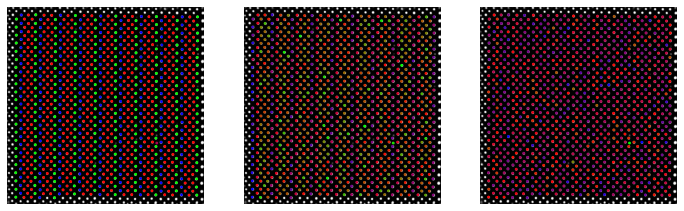

In [ ]:
gs2 = gridspec.GridSpec(1, 3)
fig2 = plt.figure(figsize = (12,4))  

for i in range(3):
    ax2 = fig2.add_subplot(gs2[i])
#      plt.imshow(work_image, cmap="gray", origin = 'lower')
    plt.axis('off')
    plt.imshow(work_image, cmap="gray")
    plt.scatter(com_i[:, 1], com_i[:, 0], c=z_all_i[:, i], s = 3,cmap = 'brg')
    plt.axis('off')
plt.show()

In [ ]:
import seaborn as sns
import pandas as pd

cols = np.hstack((np.expand_dims(z1, axis = 1), z2))
cols = pd.DataFrame(cols, columns=['Angle', 'Latent 1', 'Latent 2'])
cols.tail()

Angle  Latent 1  Latent 2
20810 -0.407242  0.384306 -0.484953
20811 -0.400681  1.312406 -0.932167
20812 -1.983879 -0.475740 -0.741527
20813 -0.390465  0.824617 -0.750656
20814  1.178743 -1.480429  1.390050

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


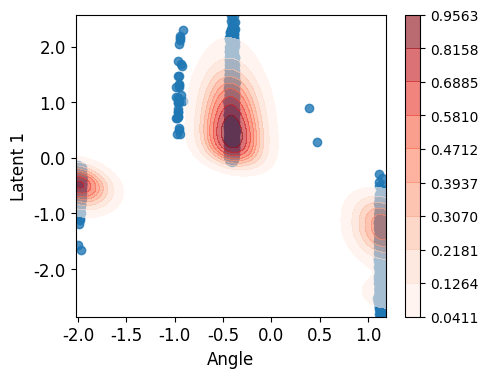

In [ ]:
x = cols['Angle']
y = cols['Latent 1']

plt.figure(num = 5, figsize=(5,4), dpi = 100)
ax = sns.regplot(x, y, fit_reg = False)
ax = sns.kdeplot(x, y, cmap="Reds", shade=True, shade_lowest=False, cut = 0, alpha = 0.6, cbar = True)
ax.set_xlabel(xlabel = ax.get_xlabel(), fontdict={'fontsize' : 12})
ax.set_ylabel(ylabel = ax.get_ylabel(), fontdict={'fontsize' : 12})
ax.set_xticklabels(np.round(ax.get_xticks(), decimals=2), size = 12)
ax.set_yticklabels(np.round(ax.get_yticks(), decimals=2), size = 12)
ax.figure.axes[-1].yaxis.label.set_size(4)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


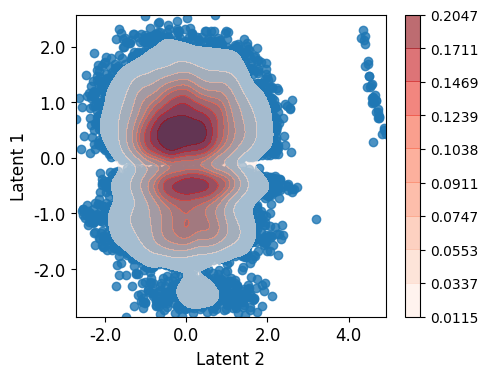

In [ ]:
x = cols['Latent 2']
y = cols['Latent 1']

plt.figure(num = 5, figsize=(5,4), dpi = 100)
ax = sns.regplot(x, y, fit_reg = False)
ax = sns.kdeplot(x, y, cmap="Reds", shade=True, shade_lowest=False, cut = 0, alpha = 0.6, cbar = True)
ax.set_xlabel(xlabel = ax.get_xlabel(), fontdict={'fontsize' : 12})
ax.set_ylabel(ylabel = ax.get_ylabel(), fontdict={'fontsize' : 12})
ax.set_xticklabels(np.round(ax.get_xticks(), decimals=2), size = 12)
ax.set_yticklabels(np.round(ax.get_yticks(), decimals=2), size = 12)
ax.figure.axes[-1].yaxis.label.set_size(4)
plt.show()

In [ ]:
#Here we can color-code the experimental image/frame based on the latent variable values

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

nc = 3
z = z3
#z[:,0] = z1
#sample = 'SRO'
sample = 'LSMO'


gmm = GaussianMixture(n_components=nc, covariance_type='full', random_state=42) #diag
gmm_zt = gmm.fit_predict(z)

if sample == 'SRO':
  frame = 0 # select frame
  wsize = stack_sro.shape[1]
  imgdata = imgdata_sro
  stack = stack_sro
  com_single = com_sro[np.where(frames_sro == frame)] # get coordinates for this frame
  gmm_zt_i = gmm_zt[np.where(frames_sro == frame)] # get latent variables for this frame
  stack_mean = stack_sro[:, :,:, 0].mean(axis = 0)  
elif sample == 'LSMO':
  frame = 0 # select frame
  wsize = stack_lsmo.shape[1]
  imgdata = imgdata_lsmo
  stack = stack_lsmo
  com_single = com_lsmo[np.where(frames_lsmo == frame)] # get coordinates for this frame
  gmm_zt_i = gmm_zt[np.where(frames_lsmo == frame)] # get latent variables for this frame
  stack_mean = stack_lsmo[:, :,:, 0].mean(axis = 0) 
else:
  print('No such sample')


plt.figure(figsize=(12, 12))
#plt.imshow(imgdata[frame,:,:], cmap = 'gray', origin = 'lower')
plt.imshow(imgdata[frame,:,:], cmap = 'gray')

plt.scatter(com_single[:,1], com_single[:,0], c=gmm_zt_i, cmap = 'jet')

plt.axis('off')
plt.colorbar(shrink = 0.6)
plt.show()

rows = int(np.ceil(float(nc)/4))
cols = int(np.ceil(float(nc)/rows))

gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))   
for i in range(nc):
    ax2 = fig2.add_subplot(gs2[i])
#    ax2.imshow(stack[gmm_zt == i, :].mean(axis = 0).reshape(wsize, wsize) - stack_mean, cmap = 'jet')
    ax2.imshow(stack[gmm_zt == i, :].mean(axis = 0).reshape(wsize, wsize) - stack_mean, cmap = 'jet')

    ax2.set_title('Component ' + str(i + 1))
    plt.tick_params(labelsize = 18)
    plt.axis('off')
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(z3[:, 0], z3[:,1], c=gmm_zt, cmap="jet")
plt.xlabel("Latent 1", fontsize = 18)
plt.ylabel("Latent 2", fontsize = 18)
plt.tick_params(labelsize = 18)

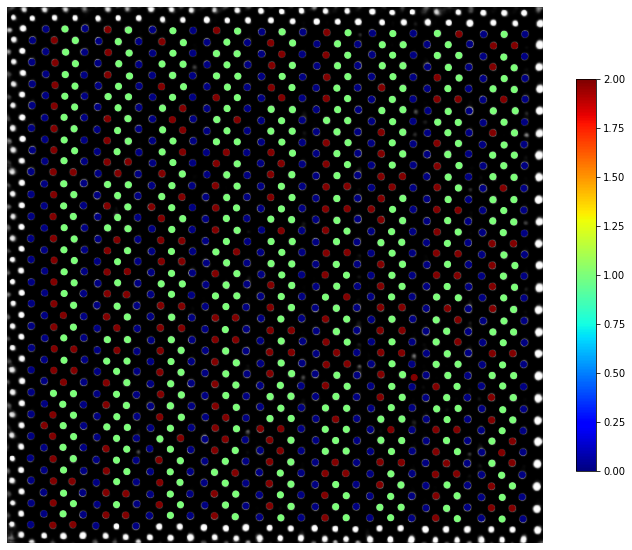

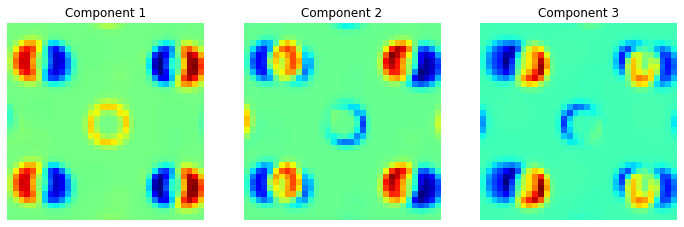

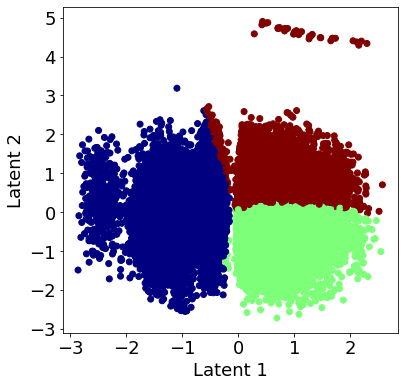

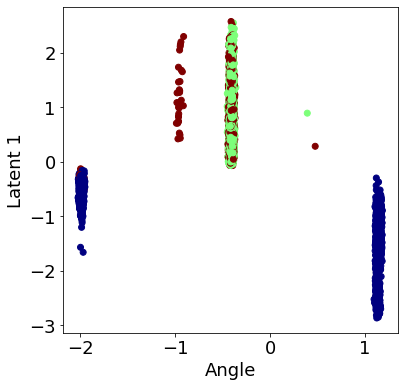

In [ ]:
#Here we can color-code the experimental image/frame based on the latent variable values

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

nc = 3
z = z2

gmm = GaussianMixture(n_components=nc, covariance_type='full', random_state=42) #diag
gmm_zt = gmm.fit_predict(z)

frame = 0 # select frame
wsize = stack.shape[1]
com_single = com[np.where(frames == frame)] # get coordinates for this frame
gmm_zt_i = gmm_zt[np.where(frames == frame)] # get latent variables for this frame
stack_mean = stack[:, :,:, 0].mean(axis = 0) 


plt.figure(figsize=(12, 12))
#plt.imshow(imgdata[frame,:,:], cmap = 'gray', origin = 'lower')
plt.imshow(imgdata[frame,:,:,0], cmap = 'gray')

plt.scatter(com_single[:,1], com_single[:,0], c=gmm_zt_i, cmap = 'jet')

plt.axis('off')
plt.colorbar(shrink = 0.6)
plt.show()

rows = int(np.ceil(float(nc)/4))
cols = int(np.ceil(float(nc)/rows))

gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))   
for i in range(nc):
    ax2 = fig2.add_subplot(gs2[i])
#    ax2.imshow(stack[gmm_zt == i, :].mean(axis = 0).reshape(wsize, wsize) - stack_mean, cmap = 'jet')
    ax2.imshow(stack[gmm_zt == i, :].mean(axis = 0).reshape(wsize, wsize) - stack_mean, cmap = 'jet')

    ax2.set_title('Component ' + str(i + 1))
    plt.tick_params(labelsize = 18)
    plt.axis('off')
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(z2[:, 0], z2[:,1], c=gmm_zt, cmap="jet")
plt.xlabel("Latent 1", fontsize = 18)
plt.ylabel("Latent 2", fontsize = 18)
plt.tick_params(labelsize = 18)

plt.figure(figsize=(6,6))
plt.scatter(z1[:], z2[:,0], c=gmm_zt, cmap="jet")
plt.xlabel("Angle", fontsize = 18)
plt.ylabel("Latent 1", fontsize = 18)
plt.tick_params(labelsize = 18)



In [ ]:
gmm_zt_i

array([1, 1, 1, ..., 1, 0, 4])

Use crVAE

In [ ]:
input_dim = (window, window)

# Intitialize model
rvae = aoi.models.rVAE(input_dim, translation = False, nb_classes=3) 
# Train
rvae.fit(np.squeeze(stack), gmm_zt_i, training_cycles=1000, batch_size=32)


Epoch: 1/1000, Training loss: 13.1448
Epoch: 2/1000, Training loss: 9.9592
Epoch: 3/1000, Training loss: 9.8399
Epoch: 4/1000, Training loss: 9.7514
Epoch: 5/1000, Training loss: 9.6908
Epoch: 6/1000, Training loss: 9.6446
Epoch: 7/1000, Training loss: 9.6138
Epoch: 8/1000, Training loss: 9.5715
Epoch: 9/1000, Training loss: 9.5484
Epoch: 10/1000, Training loss: 9.5297
Epoch: 11/1000, Training loss: 9.5167
Epoch: 12/1000, Training loss: 9.5000
Epoch: 13/1000, Training loss: 9.4767
Epoch: 14/1000, Training loss: 9.4660
Epoch: 15/1000, Training loss: 9.4390
Epoch: 16/1000, Training loss: 9.4245
Epoch: 17/1000, Training loss: 9.3981
Epoch: 18/1000, Training loss: 9.3689
Epoch: 19/1000, Training loss: 9.3405
Epoch: 20/1000, Training loss: 9.2963
Epoch: 21/1000, Training loss: 9.2289
Epoch: 22/1000, Training loss: 9.1341
Epoch: 23/1000, Training loss: 9.0430
Epoch: 24/1000, Training loss: 8.9166
Epoch: 25/1000, Training loss: 8.8107
Epoch: 26/1000, Training loss: 8.7139
Epoch: 27/1000, Trai

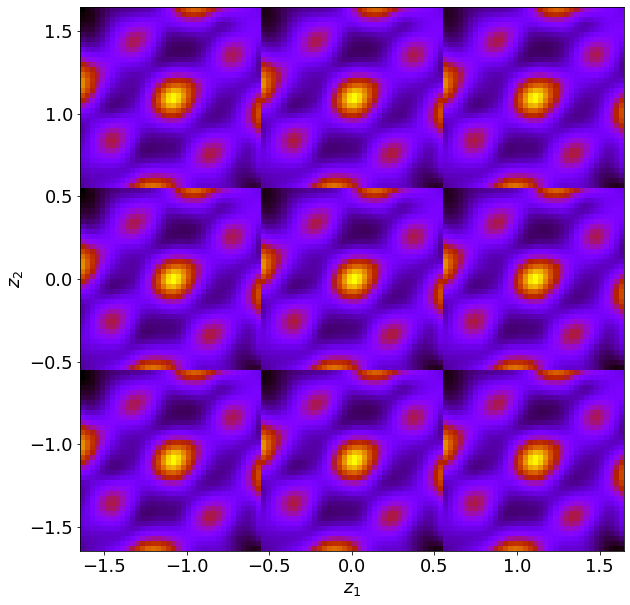

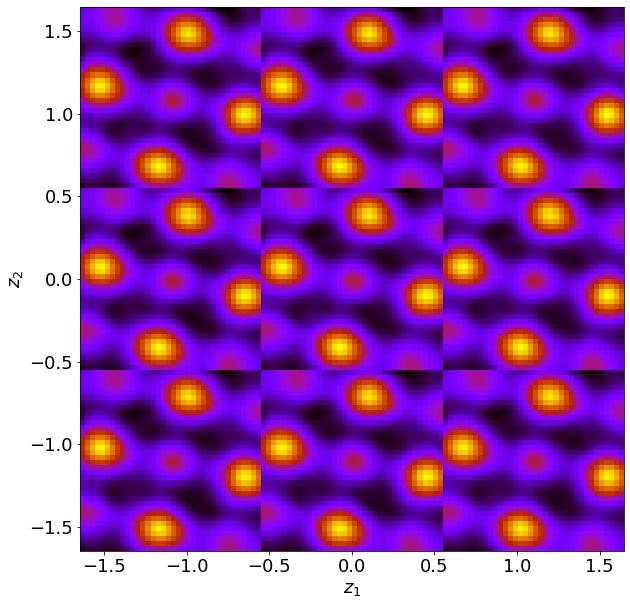

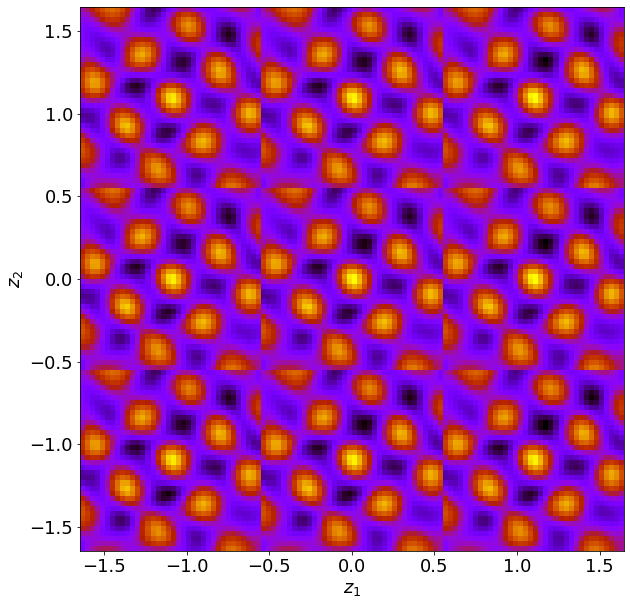

In [ ]:
for i in range(3):
    rvae.manifold2d(label=i, d=3, origin="upper")